In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [168]:
class PublicGoodsModel():
    
    def plot_grid_richness(self):
        plot_grid_revenue = np.zeros((self.width, self.height),dtype=np.float64) 
        for x in range(self.width):
            for y in range(self.height):
                richness = self.grid[x][y].status
                if richness == 'Rich':
                    plot_grid_revenue[x][y] = 1
                elif richness == 'Poor':
                    plot_grid_revenue[x][y] = 0
        x = np.arange(self.width + 1)
        y = np.arange(self.height + 1)
        fig, ax = plt.subplots()
        ax.set_title('Richness')
        ax.pcolormesh(x, y, plot_grid_revenue, shading='flat', vmin=0, vmax=1)
        
    def plot_grid_strategy(self):
        plot_grid_strat = np.zeros((self.width, self.height),dtype=np.float64)
        for x in range(self.width):
            for y in range(self.height):
                strat = self.grid[x][y].strategy
                if strat == 'D':
                    plot_grid_strat[x][y] = 0
                elif strat == 'C':
                    plot_grid_strat[x][y] = 1
        x = np.arange(self.width + 1)
        y = np.arange(self.height + 1)
        fig, ax = plt.subplots()
        ax.set_title('Cooperation')
        ax.pcolormesh(x, y, plot_grid_strat, shading='flat', vmin=0, vmax=1)
        
    def __init__(self, density, width, height, r_factor, density_def, richness_threshold, R1=1, R2=1):
        self.grid = np.zeros((width, height),dtype=EconomicAgent)
        self.width, self.height = width, height
        self.r_factor = r_factor
        self.R1, self.R2 = R1, R2
        self.b_pay = 2/self.r_factor
        self.c_pay = (R2-R1)/R1
        self.defectors, self.cooperators = np.array([]), np.array([])
        ag_id, self.N = 0, 0
        self.agents = []
        for x in range(self.width):
            for y in range(self.height):
                fate = random.uniform(0,1)
                if fate <= richness_threshold:
                    fate = 0 # Poor Agent
                else:
                    fate = 1 # Rich Agent
                if density >= random.random():
                    ag = EconomicAgent(ag_id, random.uniform(0,1), self.width, self.height, density_def, fate)
                    ag.set_coord(x,y)
                    self.agents.append(ag)
                    self.grid[x][y] = ag
                    ag_id += 1
                    self.N += 1
                else:
                    ag = EconomicAgent(ag_id, 0, self.width, self.height, density_def, fate)
                    ag.set_coord(x,y)
                    self.agents.append(ag)
                    self.grid[x][y] = ag
                    ag_id += 1
        
    def payoff_matrix(self, status_one, status_two, strat_one, strat_two):
        if status_one == 'Rich':
            if status_two == 'Rich':
                if strat_one == 'C':
                    if strat_two == 'C': # CC RICH-RICH
                        return (2*self.c_pay) + 1
                    else: # CD RICH-RICH
                        return self.c_pay
                else:
                    if strat_two == 'C': # DC RICH-RICH
                        return (self.c_pay*self.b_pay) + self.b_pay + self.c_pay
                    else: # DD RICH-RICH
                        return (self.c_pay*self.b_pay) + self.b_pay - 1
            else:
                if strat_one == 'C':
                    if strat_two == 'C': # CC RICH-POOR
                        return self.c_pay + 1
                    else: # CD RICH-POOR
                        return self.c_pay
                else:
                    if strat_two == 'C': # DC RICH-POOR
                        return (self.c_pay*self.b_pay) + self.b_pay
                    else: # DD RICH-POOR
                        return (self.c_pay*self.b_pay) + self.b_pay - 1
        else: # Poor
            if status_two == 'Rich':
                if strat_one == 'C':
                    if strat_two == 'C': # CC POOR-RICH
                        return self.c_pay + 1
                    else: # CD POOR-RICH
                        return 0
                else:
                    if strat_two == 'C': # DC POOR-RICH
                        return self.c_pay + self.b_pay
                    else: # DD POOR-RICH
                        return self.b_pay - 1
            else:
                if strat_one == 'C':
                    if strat_two == 'C': # CC POOR-POOR
                        return 1
                    else: # CD POOR-POOR
                        return 0
                else:
                    if strat_two == 'C': # DC POOR-POOR
                        return self.b_pay
                    else: # DD POOR-POOR
                        return self.b_pay - 1
                    
    def change_strategy(self, agent_strat, neighbors_strategy, neighbors_payoffs):
        def inverse(strat):
            x = random.uniform(0,1)
            if x <= 0.05:
                if strat == 'C':
                    return 'D'
                elif strat == 'D':
                    return 'C'
            else:
                return strat
        total_payoff = neighbors_payoffs[-1]
        if total_payoff != 0:
            p = random.uniform(0,1)
            #print(p*neighbors_payoffs[-1])
            if p <= neighbors_payoffs[0]/total_payoff:
                return inverse(neighbors_strategy[0])
            elif p <= (neighbors_payoffs[1])/total_payoff:
                return inverse(neighbors_strategy[1])
            elif p <= (neighbors_payoffs[2])/total_payoff:
                return inverse(neighbors_strategy[2])
            elif p <= (neighbors_payoffs[3])/total_payoff:
                return inverse(neighbors_strategy[3])
            else:
                return inverse(neighbors_strategy[4])
        else:
            return inverse(neighbors_strategy[4])
        
    def step(self):
        coop, defe = 0, 0
        for agent in self.agents:
            neighbors = agent.get_neighbors(self.width, self.height)
            agent_act, agent_wealth, agent_status, agent_strat = agent.get_general_status()
            if agent_act:
                for neighbor in neighbors:
                    act, wealth, status, strat = self.grid[neighbor[0]][neighbor[1]].get_general_status()
                    if act:
                        payoff = PublicGoodsModel.payoff_matrix(self, agent_status, status, agent_strat, strat)
                        agent.payoff = payoff
                        self.grid[neighbor[0]][neighbor[1]].payoff = payoff
        # CHANGE STRATEGY
        for agent in self.agents:
            neighbors = agent.get_neighbors(self.width, self.height)
            agent_act, agent_wealth, agent_status, agent_strat = agent.get_general_status()
            if agent_act:
                neighbors_payoff = []
                neighbors_strategy = []
                for n_agent in range(len(neighbors)):
                    neighbor = neighbors[n_agent]
                    act, wealth, status, strat = self.grid[neighbor[0]][neighbor[1]].get_general_status()
                    if act:
                        neighbors_payoff.append(self.grid[neighbor[0]][neighbor[1]].payoff)
                        neighbors_strategy.append(self.grid[neighbor[0]][neighbor[1]].strategy)
                        if n_agent > 0:
                            neighbors_payoff[n_agent] += neighbors_payoff[n_agent-1]
                neighbors_payoff.append(agent.payoff)
                neighbors_payoff[-1] += neighbors_payoff[-2]
                neighbors_strategy.append(agent_strat)
                agent.strategy = PublicGoodsModel.change_strategy(self, agent_strat, neighbors_strategy, neighbors_payoff)
                if agent.strategy == 'C':
                    coop += 1
                elif agent.strategy == 'D':
                    defe += 1
        self.defectors = np.append(self.defectors,values=(defe/self.N),axis=None)
        self.cooperators = np.append(self.cooperators,values=(coop/self.N),axis=None)
        
    def plot_population_strategies(self):
        fig, ax = plt.subplots()
        x = np.linspace(0, 1, len(self.defectors))
        ax.set_title('Cooperators x Defectors')
        ax.plot(x, self.cooperators, 'b')
        ax.plot(x, self.defectors, 'r')

class EconomicAgent():
    
    def set_coord(self, x, y):
        self.x = x
        self.y = y
    
    def __init__(self, ag_id, wealth, width, height, initial_defectors, condition):
        self.id = ag_id
        self.payoff = 0
        self.wealth = wealth
        if wealth == 0:
            self.activity = False # Dead Agent
        else:
            if condition == 0:
                self.activity = True # Alive
                self.status = 'Poor'
            elif condition == 1:
                self.activity = True # Alive
                self.status = 'Rich'
        # AGENT'S STRATEGY
        if random.uniform(0,1) < initial_defectors:
            self.strategy = "D"
        else:
            self.strategy = "C"
        
    def get_neighbors(self, x_border, y_border, x_thresh=0, y_tresh=0):
        if type(x_border)==int and type(y_border)==int:
            # Horizontal Neighbors
            if self.x == x_border-1:
                right_neighbor = [0, self.y]
                left_neighbor = [self.x-1, self.y]
            elif self.x == 0:
                right_neighbor = [self.x+1, self.y]
                left_neighbor = [x_border-1, self.y]
            else:
                right_neighbor = [self.x+1, self.y]
                left_neighbor = [self.x-1, self.y]
            # Vertical Neighbors
            if self.y == y_border-1:
                upper_neighbor = [self.x, 0]
                lower_neighbor = [self.x, self.y-1]
            elif self.y == 0:
                upper_neighbor = [self.x, self.y+1]
                lower_neighbor = [self.x, y_border-1]
            else:
                upper_neighbor = [self.x, self.y+1]
                lower_neighbor = [self.x, self.y-1]
            # Clockwise direction 
            return upper_neighbor, right_neighbor, lower_neighbor, left_neighbor
        else:
            return None
        
    def get_general_status(self):
        return self.activity, self.wealth, self.status, self.strategy
        
    def get_coord(self):
        return self.x, self.y

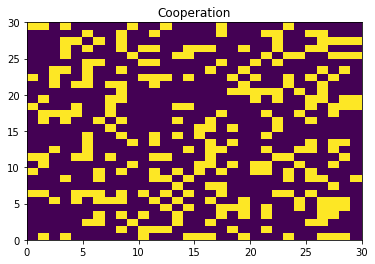

In [187]:
model = PublicGoodsModel(density=1, width=30, height=30, r_factor=100, density_def=0.7, richness_threshold=0.6, R1=1, R2=1)
model.plot_grid_strategy()

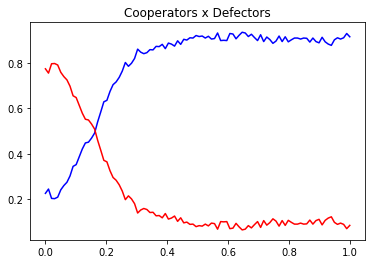

In [188]:
for x in range(100):
    model.step()
model.plot_population_strategies()

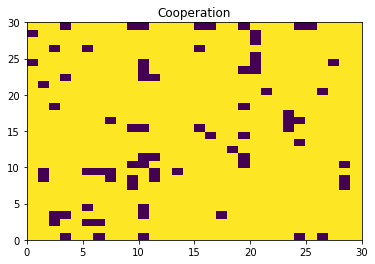

In [189]:
model.plot_grid_strategy()